In [0]:
import os
import re
import sys
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

In [0]:
from torch.autograd import Variable

In [0]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

###  Load  CIFAR-10 Dataset

In [0]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [0]:
batchsize = 64

In [6]:
trainset = torchvision.datasets.CIFAR10(root=' ', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batchsize,
                                          shuffle=True, num_workers=1)

0it [00:00, ?it/s]

170500096it [00:03, 52088493.84it/s]                               


In [7]:
testset = torchvision.datasets.CIFAR10(root=' ', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batchsize,
                                         shuffle=False, num_workers=1)

Files already downloaded and verified


In [0]:
numclasses = 10

In [0]:
def to_categorical(ytrue):
  input_shape = ytrue.size()
  n = ytrue.size(0)
  categorical = torch.zeros(n, numclasses).to(device)
  categorical[torch.arange(n), ytrue] = 1
  output_shape = input_shape + (numclasses,)
  categorical = torch.reshape(categorical, output_shape)
  return categorical

### Focal Loss

In [0]:
class FocalLoss(nn.Module):
  def __init__(self,reduction='mean',alpha=0.01,gamma=1):
    super(FocalLoss,self).__init__()
    self.reduction = reduction
    self.alpha = alpha
    self.gamma = gamma
    
  def forward(self,ypred,ytrue):
    logpt = F.log_softmax(ypred,1) 
    pt = Variable(torch.exp(logpt))
    ytrue = to_categorical(ytrue)
    pt_prime = 1 - pt
    focalloss = -self.alpha * (pt_prime)**self.gamma * ytrue * logpt
    focalloss = torch.sum(focalloss,1)
    if(self.reduction=='sum'):
      return focalloss.sum()
    else:
      return focalloss.mean()

### Hyperparameters


In [0]:
numclasses = 10
epochs = 20
learning_rate = 0.001

In [0]:
class Model(nn.Module):
  def __init__(self):
    super(Model,self).__init__()
    self.numclasses = numclasses
    self.conv1 = nn.Conv2d(3, 6, 5)
    self.pool = nn.MaxPool2d(2, 2)
    self.conv2 = nn.Conv2d(6, 16, 5)
    self.fc1 = nn.Linear(16 * 5 * 5, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)
    
  def forward(self, x):
    out = self.pool(F.relu(self.conv1(x)))
    out = self.pool(F.relu(self.conv2(out)))
    out = out.view(out.size(0),-1)
    out = F.relu(self.fc1(out))
    out = F.relu(self.fc2(out))
    out = self.fc3(out)
    return out

In [0]:
model = Model().to(device)

In [0]:
def evaluate(net,loader):
  with torch.no_grad():
    net.eval()
    total = 0.0
    correct = 0.0
    for images,labels in loader:
      images,labels = images.to(device),labels.to(device)
      
      total+=images.size(0)
      output = net(images).to(device)
      pred = torch.max(output,1)[1]
      correct+=(torch.sum(pred==labels.data)).item()
      
    return round((correct/total)*100,2)

### Categorical Cross Entropy Loss Training

In [34]:
model = Model().to(device)

criterion = nn.CrossEntropyLoss(reduction='sum')
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


cce_trainloss = []
cce_trainacc = []
model.train()
for epoch in range(1,epochs+1):
  model.train()
  trainloss = 0.0
  total = 0.0
  for images,labels in trainloader:
    images,labels = images.to(device),labels.to(device)
    optimizer.zero_grad()

    output = model(images).to(device)
    curloss = criterion(output,labels)
    
    curloss.backward()
    optimizer.step()
    
    trainloss+=curloss.item()
    total+=images.size(0)
    
  trainloss = (trainloss/total)
  trainloss = round(trainloss,2)
  cce_trainloss.append(trainloss)
  
  trainacc = evaluate(model,trainloader)
  cce_trainacc.append(trainacc)
  print("Epoch {} Train Loss {} Train Acc {} ".format(epoch,trainloss,trainacc))
  

testacc = evaluate(model,testloader)
print("Test Accuracy {} ".format(testacc))

Epoch 1 Train Loss 1.67 Train Acc 47.58 
Epoch 2 Train Loss 1.39 Train Acc 53.02 
Epoch 3 Train Loss 1.25 Train Acc 58.08 
Epoch 4 Train Loss 1.16 Train Acc 60.91 
Epoch 5 Train Loss 1.09 Train Acc 63.32 
Epoch 6 Train Loss 1.04 Train Acc 64.42 
Epoch 7 Train Loss 1.0 Train Acc 65.46 
Epoch 8 Train Loss 0.96 Train Acc 67.76 
Epoch 9 Train Loss 0.92 Train Acc 68.75 
Epoch 10 Train Loss 0.89 Train Acc 70.66 
Epoch 11 Train Loss 0.86 Train Acc 72.29 
Epoch 12 Train Loss 0.84 Train Acc 71.89 
Epoch 13 Train Loss 0.81 Train Acc 73.29 
Epoch 14 Train Loss 0.79 Train Acc 74.81 
Epoch 15 Train Loss 0.77 Train Acc 74.17 
Epoch 16 Train Loss 0.75 Train Acc 76.54 
Epoch 17 Train Loss 0.73 Train Acc 76.29 
Epoch 18 Train Loss 0.71 Train Acc 77.15 
Epoch 19 Train Loss 0.69 Train Acc 77.56 
Epoch 20 Train Loss 0.67 Train Acc 77.79 
Test Accuracy 63.54 


### Focal Loss Training

In [41]:
model = Model().to(device)

criterion = FocalLoss(reduction='sum',alpha=0.25,gamma=2)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


fl_trainloss = []
fl_trainacc = []
model.train()
for epoch in range(1,epochs+1):
  model.train()
  trainloss = 0.0
  total = 0.0
  for images,labels in trainloader:
    images,labels = images.to(device),labels.to(device)
    optimizer.zero_grad()

    output = model(images).to(device)
    curloss = criterion(output,labels)
    
    curloss.backward()
    optimizer.step()
    
    trainloss+=curloss.item()
    total+=images.size(0)
    
  trainloss = (trainloss/total)
  trainloss = round(trainloss,2)
  fl_trainloss.append(trainloss)
  
  trainacc = evaluate(model,trainloader)
  fl_trainacc.append(trainacc)
  print("Epoch {} Train Loss {} Train Acc {} ".format(epoch,trainloss,trainacc))
  

testacc = evaluate(model,testloader)
print("Test Accuracy {} ".format(testacc))

Epoch 1 Train Loss 0.29 Train Acc 47.46 
Epoch 2 Train Loss 0.23 Train Acc 54.04 
Epoch 3 Train Loss 0.2 Train Acc 56.43 
Epoch 4 Train Loss 0.19 Train Acc 58.63 
Epoch 5 Train Loss 0.17 Train Acc 61.02 
Epoch 6 Train Loss 0.16 Train Acc 62.39 
Epoch 7 Train Loss 0.16 Train Acc 64.52 
Epoch 8 Train Loss 0.15 Train Acc 65.12 
Epoch 9 Train Loss 0.14 Train Acc 64.93 
Epoch 10 Train Loss 0.13 Train Acc 66.37 
Epoch 11 Train Loss 0.13 Train Acc 67.94 
Epoch 12 Train Loss 0.12 Train Acc 67.94 
Epoch 13 Train Loss 0.12 Train Acc 68.57 
Epoch 14 Train Loss 0.11 Train Acc 69.01 
Epoch 15 Train Loss 0.11 Train Acc 71.23 
Epoch 16 Train Loss 0.11 Train Acc 70.68 
Epoch 17 Train Loss 0.1 Train Acc 72.77 
Epoch 18 Train Loss 0.1 Train Acc 73.01 
Epoch 19 Train Loss 0.09 Train Acc 72.68 
Epoch 20 Train Loss 0.09 Train Acc 74.59 
Test Accuracy 60.67 


In [50]:
model = Model().to(device)

criterion = FocalLoss(reduction='sum',alpha=1,gamma=0)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


fl_trainloss = []
fl_trainacc = []
model.train()
for epoch in range(1,epochs+1):
  model.train()
  trainloss = 0.0
  total = 0.0
  for images,labels in trainloader:
    images,labels = images.to(device),labels.to(device)
    optimizer.zero_grad()

    output = model(images).to(device)
    curloss = criterion(output,labels)
    
    curloss.backward()
    optimizer.step()
    
    trainloss+=curloss.item()
    total+=images.size(0)
    
  trainloss = (trainloss/total)
  trainloss = round(trainloss,2)
  fl_trainloss.append(trainloss)
  
  trainacc = evaluate(model,trainloader)
  fl_trainacc.append(trainacc)
  print("Epoch {} Train Loss {} Train Acc {} ".format(epoch,trainloss,trainacc))
  

testacc = evaluate(model,testloader)
print("Test Accuracy {} ".format(testacc))

Epoch 1 Train Loss 1.67 Train Acc 47.51 
Epoch 2 Train Loss 1.35 Train Acc 56.3 
Epoch 3 Train Loss 1.22 Train Acc 58.34 
Epoch 4 Train Loss 1.13 Train Acc 62.22 
Epoch 5 Train Loss 1.07 Train Acc 64.22 
Epoch 6 Train Loss 1.03 Train Acc 66.58 
Epoch 7 Train Loss 0.98 Train Acc 67.69 
Epoch 8 Train Loss 0.95 Train Acc 68.81 
Epoch 9 Train Loss 0.92 Train Acc 70.19 
Epoch 10 Train Loss 0.89 Train Acc 70.72 
Epoch 11 Train Loss 0.86 Train Acc 72.41 
Epoch 12 Train Loss 0.84 Train Acc 72.07 
Epoch 13 Train Loss 0.81 Train Acc 72.29 
Epoch 14 Train Loss 0.79 Train Acc 74.33 
Epoch 15 Train Loss 0.76 Train Acc 74.63 
Epoch 16 Train Loss 0.74 Train Acc 75.3 
Epoch 17 Train Loss 0.72 Train Acc 76.5 
Epoch 18 Train Loss 0.7 Train Acc 76.81 
Epoch 19 Train Loss 0.68 Train Acc 78.0 
Epoch 20 Train Loss 0.67 Train Acc 77.91 
Test Accuracy 62.55 


In [0]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

In [0]:
iterations = list(range(1,epochs+1))

### Plotting Loss values 

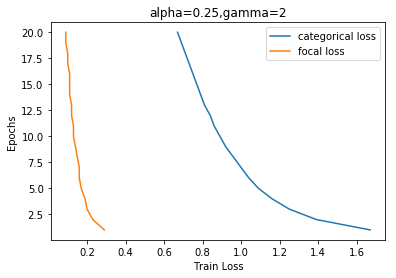

In [48]:
plt.plot(cce_trainloss,iterations,label='categorical loss')
plt.plot(fl_trainloss,iterations,label='focal loss')
plt.xlabel('Train Loss')
plt.ylabel('Epochs')
plt.title("alpha=0.25,gamma=2")
plt.legend()
plt.show()

### Plotting Accuracy Values

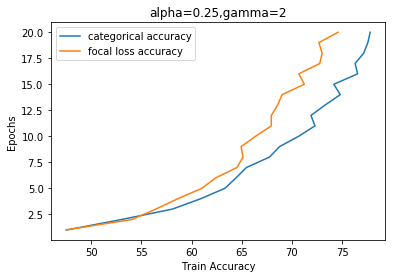

In [49]:
plt.plot(cce_trainacc,iterations,label='categorical accuracy')
plt.plot(fl_trainacc,iterations,label='focal loss accuracy')
plt.xlabel('Train Accuracy')
plt.ylabel('Epochs')
plt.title("alpha=0.25,gamma=2")
plt.legend()
plt.show()

### Plotting Loss Values

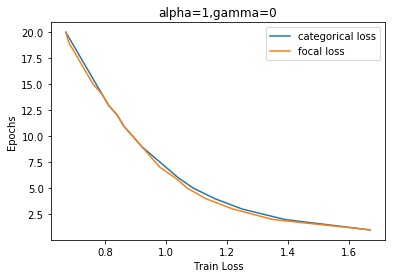

In [51]:
plt.plot(cce_trainloss,iterations,label='categorical loss')
plt.plot(fl_trainloss,iterations,label='focal loss')
plt.xlabel('Train Loss')
plt.ylabel('Epochs')
plt.title("alpha=1,gamma=0")
plt.legend()
plt.show()

### Plotting Accuracy Values

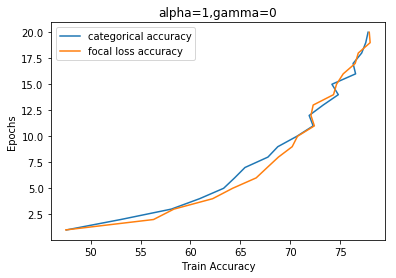

In [52]:
plt.plot(cce_trainacc,iterations,label='categorical accuracy')
plt.plot(fl_trainacc,iterations,label='focal loss accuracy')
plt.xlabel('Train Accuracy')
plt.ylabel('Epochs')
plt.title("alpha=1,gamma=0")
plt.legend()
plt.show()